## Import packages and read the data



Import the packages needed for the analysis.



In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.style.use('ggplot')

from typing import Tuple, List
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.base import TransformerMixin

# Out[1]:

Define a custom imputer class for use in dataframe that has both categorical and 
numerical variables.



In [1]:
class CategoricalNumericalImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

# Out[2]:

In [1]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Out[3]:

## Do data exploration



Using the processes presented by Hadley:

[https://r4ds.had.co.nz/exploratory-data-analysis.html](https://r4ds.had.co.nz/exploratory-data-analysis.html)

Two types of questions

-   What type of variation occurs within my variables?
-   What type of covariation occurs between my variables?

Let's visualize the categorical variables!



In [1]:
train.describe(include='all')

:results:
  # Out[4]:
  #+BEGIN_EXAMPLE
    PassengerId    Survived      Pclass                       Name   Sex  \
    count    891.000000  891.000000  891.000000                        891   891
    unique          NaN         NaN         NaN                        891     2
    top             NaN         NaN         NaN  Becker, Master. Richard F  male
    freq            NaN         NaN         NaN                          1   577
    mean     446.000000    0.383838    2.308642                        NaN   NaN
    std      257.353842    0.486592    0.836071                        NaN   NaN
    min        1.000000    0.000000    1.000000                        NaN   NaN
    25%      223.500000    0.000000    2.000000                        NaN   NaN
    50%      446.000000    0.000000    3.000000                        NaN   NaN
    75%      668.500000    1.000000    3.000000                        NaN   NaN
    max      891.000000    1.000000    3.000000                        NaN

We see, looking at describe and the data description on kaggle that,

-   Survived (which is out dependent variable)
-   Pclass,
-   Sex,
-   Cabin,
-   Embarked

are our categorical variables.

Let's visualize the proportion of survived to not survived



In [1]:
s = train.Survived.value_counts()
s.index = ["No", "Yes"]
s

:results:
  # Out[5]:
  #+BEGIN_EXAMPLE
    No     549
    Yes    342
    Name: Survived, dtype: int64
  #+END_EXAMPLE
  :end:

:results:
  # Out[6]:
  : <BarContainer object of 2 artists>
  
  :end:

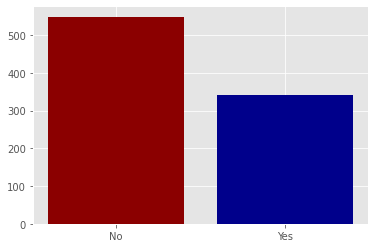

In [1]:
plt.bar(
    x=s.index,
    height=s,
    color=['darkred', 'darkblue']
)

Find proportions of the survived against the non-survived



In [1]:
s / sum(s)

:results:
  # Out[7]:
  #+BEGIN_EXAMPLE
    No     0.616162
    Yes    0.383838
    Name: Survived, dtype: float64
  #+END_EXAMPLE
  :end:

We can visualize how many survived amongst a subset of our categorical variables.



:results:
  # Out[8]:
  
  :end:

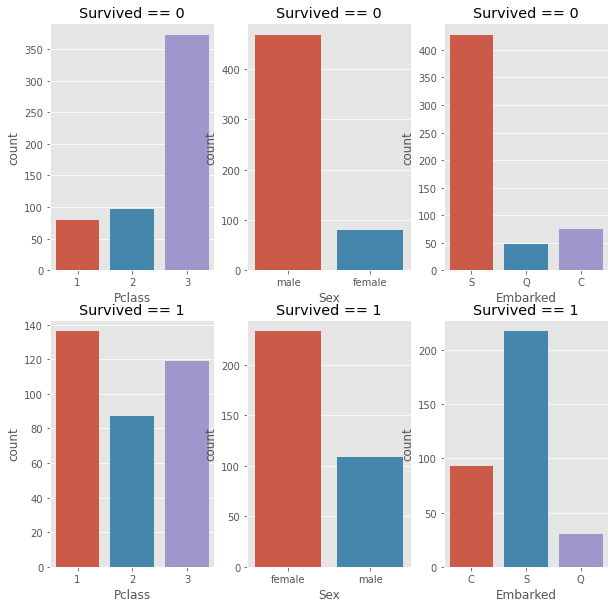

In [1]:
cat_variables = [
    'Pclass',
    'Sex',
    'Embarked'
]
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
rows, cols = range(2), range(4)
for row in rows:
    for cat_var, col in zip(cat_variables, cols):
        d = train.loc[train.Survived == row]
        sns.countplot(
            x=cat_var,
            data=train.loc[train.Survived == row],
            ax = ax[row, col]
        )
        ax[row, col].set_title("Survived == " + str(d.Survived.iloc[0]))

From which we recognize that the Pclass and Embarked has the potential of being strong predictors.

For other categorical variables we have to do some data mendling, such as Cabin, which consists of multiple cabins  for each passenger. Also we are able to subset the deck from the cabin numers, which might give us an indication of how good the predictor is.

Intuitively, the deck number should be a rather strong predictor, since the lower the deck, the more the passenger had to climbed to get to the top deck.



In [1]:
# Extract the cabins data and split into Deck and numberx
cabins = train.Cabin.str.split(" ", expand=True).fillna(np.nan)
f = lambda col: col.str.extract(r'([a-zA-Z]+)(\d+)')
cabins_split = pd.concat(
    [f(cabins[col_label]) for col_label in cabins.columns], 
    axis=1
)
ls = [
    "Deck_0", "Room_0",
    "Deck_1", "Room_1",
    "Deck_2", "Room_2",
    "Deck_3", "Room_3"
]
cabins_split.columns = ls
cabins_split

:results:
  # Out[9]:
  #+BEGIN_EXAMPLE
    Deck_0 Room_0 Deck_1 Room_1 Deck_2 Room_2 Deck_3 Room_3
    0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
    1        C     85    NaN    NaN    NaN    NaN    NaN    NaN
    2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
    3        C    123    NaN    NaN    NaN    NaN    NaN    NaN
    4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
    ..     ...    ...    ...    ...    ...    ...    ...    ...
    886    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
    887      B     42    NaN    NaN    NaN    NaN    NaN    NaN
    888    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
    889      C    148    NaN    NaN    NaN    NaN    NaN    NaN
    890    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

    [891 rows x 8 columns]
  #+END_EXAMPLE
  :end:

For the missing values, we are imputing with "Missing", which will be handled by the one-hot encoding



In [1]:
cabins_split.fillna("Missing", inplace=True)

:results:
  # Out[10]:
  :end:

Merge the datasets



In [1]:
t = pd.concat([
    train.drop(columns=["Cabin"]),
    cabins_split
], axis=1)

:results:
  # Out[11]:
  :end:

In [1]:
t.head()

:results:
  # Out[12]:
  #+BEGIN_EXAMPLE
    PassengerId  Survived  Pclass  \
    0            1         0       3
    1            2         1       1
    2            3         1       3
    3            4         1       1
    4            5         0       3

    Name     Sex   Age  SibSp  \
    0                            Braund, Mr. Owen Harris    male  22.0      1
    1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1
    2                             Heikkinen, Miss. Laina  female  26.0      0
    3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1
    4                           Allen, Mr. William Henry    male  35.0      0

    Parch            Ticket     Fare Embarked   Deck_0   Room_0   Deck_1  \
    0      0         A/5 21171   7.2500        S  Missing  Missing  Missing
    1      0          PC 17599  71.2833        C        C       85  Missing
    2      0  STON/O2. 3101282   7.9250        S  Missing  Missing  Missing
    3   

:results:
  # Out[13]:
  : <seaborn.axisgrid.FacetGrid at 0x7f95269756d8>
  
  :end:

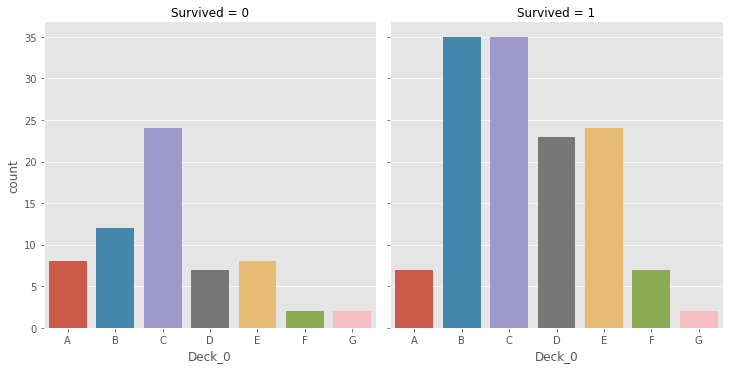

In [1]:
t_sorted = t.sort_values("Deck_0")
sns.catplot(
    x="Deck_0",
    col="Survived",
    kind="count",
    data=t_sorted.loc[t_sorted.Deck_0 != "Missing"],
)

:results:
  # Out[14]:
  : <AxesSubplot:xlabel='Deck_0', ylabel='count'>
  
  :end:

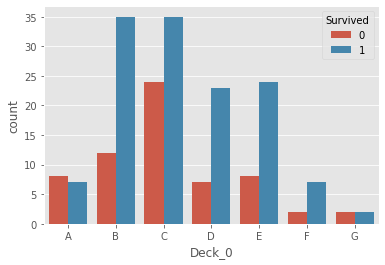

In [1]:
sns.countplot(
    x="Deck_0",
    hue="Survived",
    data=t_sorted.loc[t_sorted.Deck_0 != "Missing"]
)

The second plot tells a bit more of the deck variable. Maybe our model will be able to pick out based
  on the info from this, especially from those thatwere on the B, D, E, and F decks since these have great discrepancies between those who survived and those who didnt.

Just to check let's visualize deck 2 too.



:results:
  # Out[15]:
  : <AxesSubplot:xlabel='Deck_1', ylabel='count'>
  
  :end:

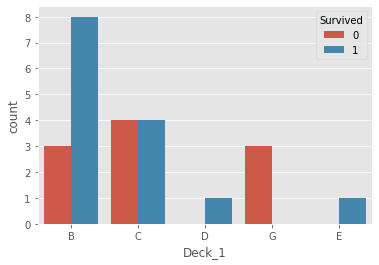

In [1]:
sns.countplot(
    x="Deck_1",
    hue="Survived",
    data=t_sorted.loc[t_sorted.Deck_1 != "Missing"]
)

I suppose the multiple cabins for 1 person suggests that they travelled multiple people. That is already
  captured in other features



:results:
  # Out[16]:
  
  :end:

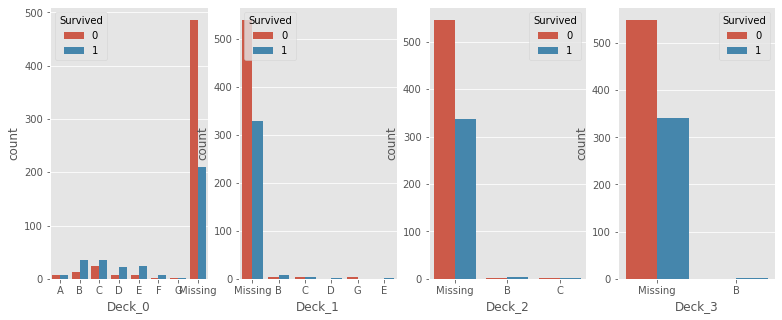

In [1]:
fig, ax = plt.subplots(1, 4, figsize=(13, 5))
for i in range(0, 4):
    sns.countplot(
        x="Deck_" + str(i),
        hue="Survived",
        data=t_sorted,
        ax=ax[i]
    )

We can also visualize our continuous variables:

-   Age,
-   Sibsp
-   Parch



:results:
  # Out[17]:
  
  :end:

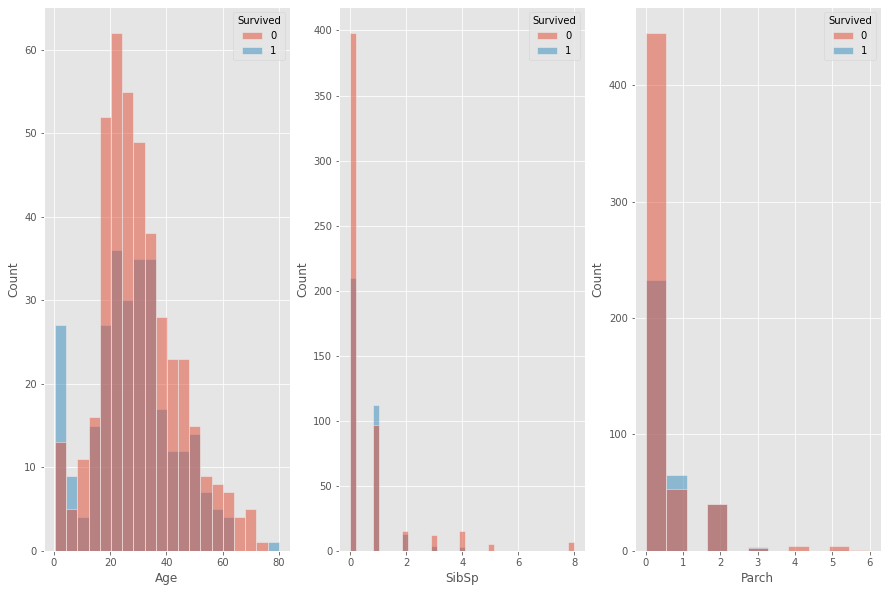

In [1]:
con_variables = [
    "Age",
    "SibSp",
    "Parch"
]
f, axs = plt.subplots(1, 3, figsize=(15, 10))
for k, var in enumerate(con_variables):
    sns.histplot(
        data=train,
        x=var,
        hue="Survived",
        ax=axs[k]
    )

## Do data transformation and drop variables, e.g. transform categorical variables to dummy variables.



Use a data preparation function, to do all prepping on both the training and test sample



In [1]:
def prepare_sample(df: pd.DataFrame, y_label: str='Survived') -> Tuple[pd.DataFrame, pd.Series]:
    labels = ['PassengerId'] if y_label is None else ['PassengerId', y_label]

    # Extract the cabins data and split into Deck and numberx
    cabins = df.Cabin.str.split(" ", expand=True).fillna(np.nan)
    f = lambda col: col.str.extract(r'([a-zA-Z]+)(\d+)')
    c_split = pd.concat(
        [f(cabins[col_label]) for col_label in cabins.columns], 
        axis=1
    )
    ls = [
        "Deck_0", "Room_0",
        "Deck_1", "Room_1",
        "Deck_2", "Room_2",
        "Deck_3", "Room_3"
    ]
    c_split.columns = ls
    t = pd.concat([df.drop("Cabin", axis=1), c_split], axis=1)
    # Drop unnecessary columns
    X = t.drop(
        labels=labels + ['Ticket', 'Name'],
        axis=1
    )
    y = None if y_label is None else df[y_label]

    return X, y

X, y = prepare_sample(
    df=train
)

:results:
  # Out[18]:
  :end:

## Run modelling



Conduct modelling, by running randomized search cv for multiple parameters



In [1]:
# Specify classifiers
clfs = {
    'rf': RandomForestClassifier(random_state=0),
}
# Setup pipelines for variable types
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)
ls = [
    "Deck_0", "Room_0",
    "Deck_1", "Room_1",
    "Deck_2", "Room_2",
    "Deck_3", "Room_3"
]
categorical_features = ['Pclass', 'Sex', 'Embarked'] + ls
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
# Set variable types
numeric_features=[
    "Age",
    "SibSp",
    "Parch"
]
# Make transofmer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  RandomForestClassifier(random_state=0))
])
# Setup hyperparameter grid
param_grid = {
    'classifier__max_depth': [0.5, 0.7],
    'classifier__n_estimators': np.arange(100, 200, 50)
}

g = GridSearchCV(
    cv=5,
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy'
).fit(X,y)

# Out[20]:

In [1]:
g.best_score_

# Out[27]:
0.6161634548992531

## Use Gridsearch results to predict on the test data



In [1]:
X_test, y_test = prepare_sample(test, None)

# Out[21]:

In [1]:
X_test.head()

# Out[22]:
#+BEGIN_EXAMPLE
  Pclass     Sex   Age  SibSp  Parch     Fare Embarked Deck_0 Room_0 Deck_1  \
  0       3    male  34.5      0      0   7.8292        Q    NaN    NaN    NaN
  1       3  female  47.0      1      0   7.0000        S    NaN    NaN    NaN
  2       2    male  62.0      0      0   9.6875        Q    NaN    NaN    NaN
  3       3    male  27.0      0      0   8.6625        S    NaN    NaN    NaN
  4       3  female  22.0      1      1  12.2875        S    NaN    NaN    NaN
  
  Room_1 Deck_2 Room_2 Deck_3 Room_3
  0    NaN    NaN    NaN    NaN    NaN
  1    NaN    NaN    NaN    NaN    NaN
  2    NaN    NaN    NaN    NaN    NaN
  3    NaN    NaN    NaN    NaN    NaN
  4    NaN    NaN    NaN    NaN    NaN
#+END_EXAMPLE

In [1]:
predictions = g.predict(X_test)

# Out[23]:

## Submit predictions



In [1]:
import datetime as dt
t = dt.datetime.today().strftime("%d%m%Y")
submission = pd.concat([
    test.PassengerId,
    pd.Series(predictions)
], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission.to_csv(f"./submissions/submission_{t}.csv", index=False)

# Out[37]:

In [1]:
import os
os.system(f"kaggle competitions submit -c titanic -f submissions/submission_{t}.csv -m 'Submission {t}'")

# Out[38]:
0